In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
(x_train,_),(x_test,_) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = np.expand_dims(x_train,axis=3)
x_test = np.expand_dims(x_test,axis=3)
print((x_train.shape,x_test.shape))

11493376/11490434 [==============================] - 0s 0us/step
((60000, 28, 28, 1), (10000, 28, 28, 1))


In [3]:
latent_dim = 4

In [4]:
input_layer = layers.Input(shape=(28,28,1))
encode = layers.Conv2D(64,(5,5),padding='same',activation='relu')(input_layer)
encode = layers.MaxPooling2D((2,2),padding='same',strides=(2,2))(encode)
encode = layers.Conv2D(64,(3,3),activation='relu')(encode)
encode = layers.MaxPooling2D((2,2),padding='same',strides=(2,2))(encode)
encode = layers.Conv2D(32,(3,3),activation='relu')(encode)
encode = layers.MaxPooling2D((2,2),padding='same',strides=(2,2))(encode)
encode = layers.Conv2D(64,(3,3),activation='relu',padding='same')(encode)
encode = layers.MaxPooling2D((2,2),padding='same')(encode)
encode = layers.Flatten()(encode)
encode = layers.Dense(32,activation='relu')(encode)

In [5]:
def latent_feature(distribution):
    mean,sigma = distribution
    batch_size = tf.shape(sigma)[0]
    epsilon = tf.keras.backend.random_normal(tf.shape(sigma),mean=0,stddev=0.1)

    z = mean + tf.exp(sigma*0.5)*epsilon
    return z

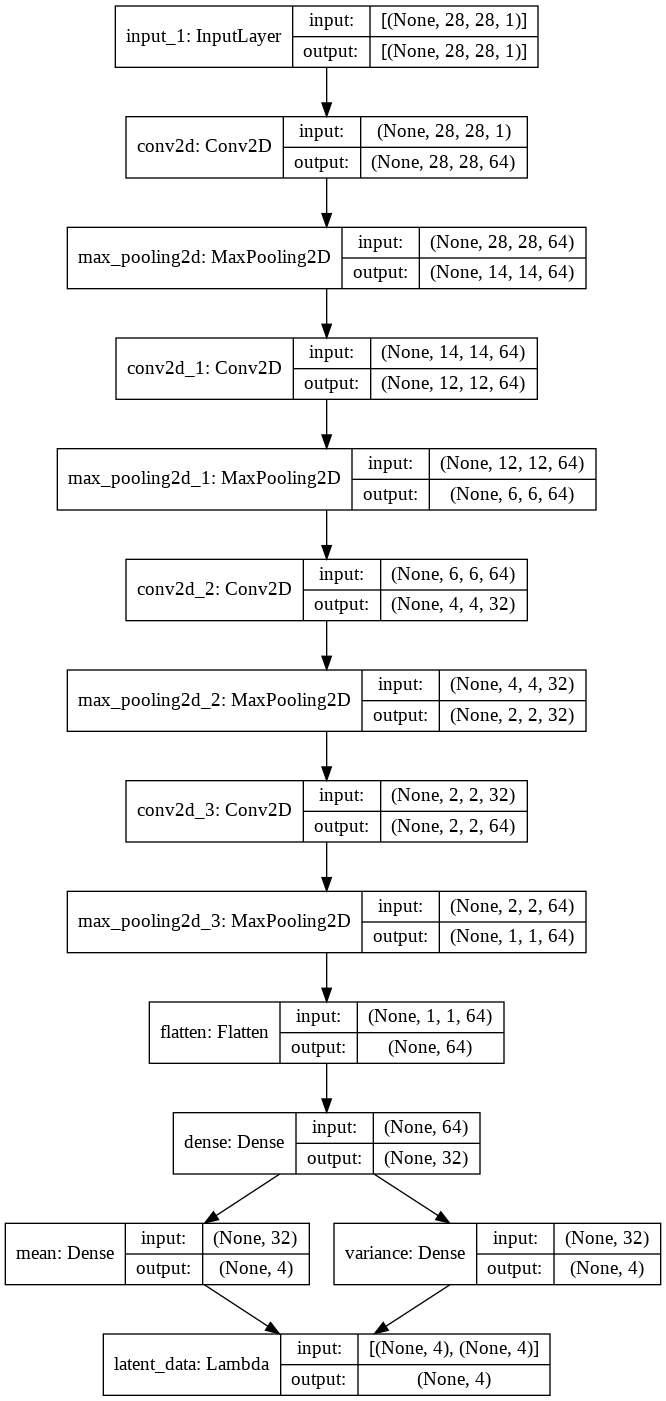

In [6]:
mean = layers.Dense(latent_dim,name='mean')(encode)
variance = layers.Dense(latent_dim,name='variance')(encode)
encoded_data = layers.Lambda(latent_feature,name='latent_data')([mean,variance])

encoder = Model(input_layer,encoded_data)
tf.keras.utils.plot_model(encoder,show_shapes=True)

In [7]:
decoder_input = layers.Input(shape=(latent_dim,))
decode = layers.Dense(64,activation='relu')(decoder_input)
decode = layers.Reshape((1,1,64))(decode)
decode = layers.UpSampling2D((2,2))(decode)
decode = layers.Conv2DTranspose(32,(3,3),padding='same',activation='relu')(decode)
decode = layers.UpSampling2D((2,2))(decode)
decode = layers.Conv2DTranspose(64,(3,3),activation='relu')(decode)
decode = layers.UpSampling2D((2,2))(decode)
decode = layers.Conv2DTranspose(64,(3,3),activation='relu')(decode)
decode = layers.UpSampling2D((2,2))(decode)
decoded_data = layers.Conv2DTranspose(1,(5,5),padding='same',activation='relu')(decode)


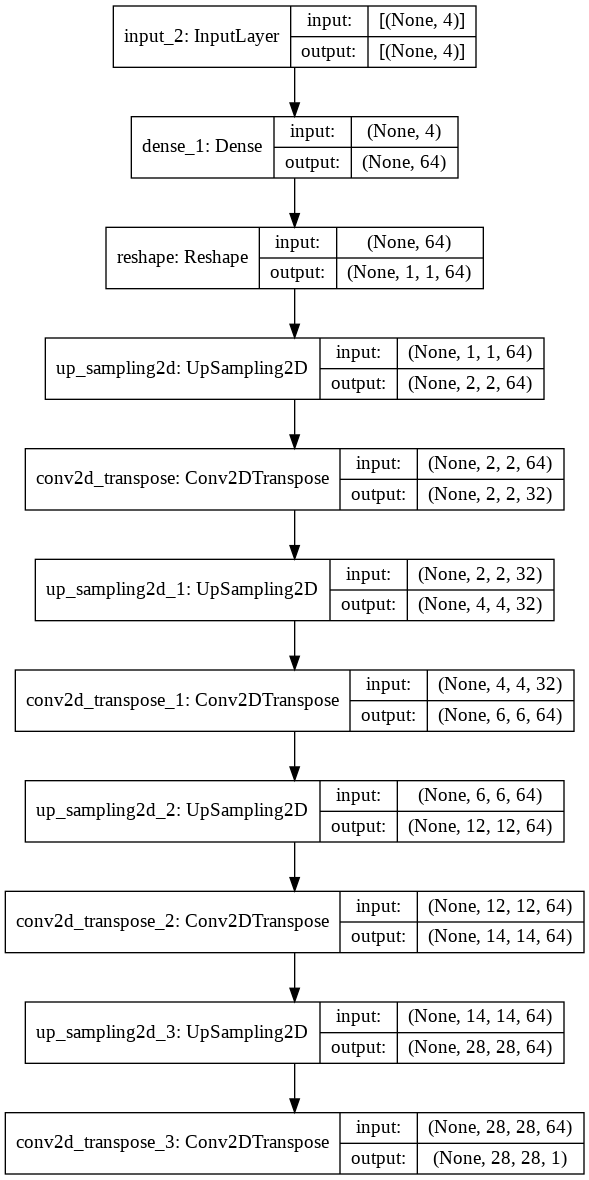

In [8]:
decoder = Model(decoder_input,decoded_data)
tf.keras.utils.plot_model(decoder,show_shapes=True)

In [10]:
encoded = encoder(input_layer)
decoded = decoder(encoded)
vae = Model(input_layer,decoded)
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 4)                 77896     
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         75809     
Total params: 153,705
Trainable params: 153,705
Non-trainable params: 0
_________________________________________________________________


In [11]:

def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

In [12]:
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

vae.compile(optimizer='adam',loss=get_loss(mean,variance),experimental_run_tf_function=False)
vae.fit(x_train,x_train,batch_size=512,epochs=30)

Train on 60000 samples
Epoch 1/30
60000/60000 [==============================] - 43s 713us/sample - loss: 54.2755
Epoch 2/30
60000/60000 [==============================] - 5s 87us/sample - loss: 37.9466
Epoch 3/30
60000/60000 [==============================] - 5s 88us/sample - loss: 30.2440
Epoch 4/30
60000/60000 [==============================] - 5s 88us/sample - loss: 28.0247
Epoch 5/30
60000/60000 [==============================] - 5s 89us/sample - loss: 26.7331
Epoch 6/30
60000/60000 [==============================] - 5s 89us/sample - loss: 26.0640
Epoch 7/30
60000/60000 [==============================] - 5s 89us/sample - loss: 25.5248
Epoch 8/30
60000/60000 [==============================] - 5s 89us/sample - loss: 25.1098
Epoch 9/30
60000/60000 [==============================] - 5s 89us/sample - loss: 24.7672
Epoch 10/30
60000/60000 [==============================] - 5s 89us/sample - loss: 24.4565
Epoch 11/30
60000/60000 [==============================] - 5s 89us/sample - loss: 24

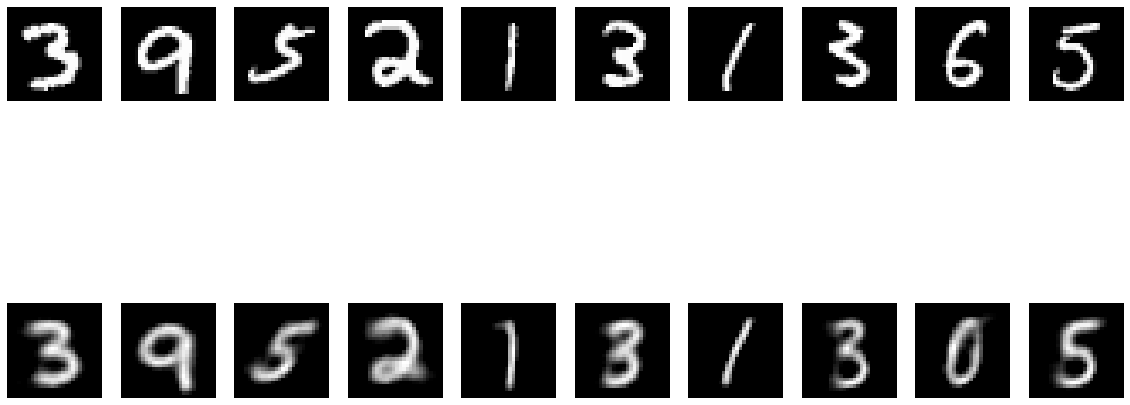

In [17]:
n = 10
x_test = x_test.reshape(10000,28,28,1)
output_imgs = vae.predict(x_test)
x_test_imgs = x_test.reshape(10000,28,28)
output_imgs = output_imgs.reshape(10000,28,28)
plt.figure(figsize=(20,10))
for i in range(n):
  plt.subplot(2,n,i+1)
  plt.imshow(x_test_imgs[500+i],cmap='gray')
  plt.axis('off')

  plt.subplot(2,n,i+1+n)
  plt.imshow(output_imgs[500+i],cmap='gray')
  plt.axis('off')
plt.show()

In [18]:
encoded_imgs = encoder.predict(x_test)
print(encoded_imgs.shape)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(10000, 4)


In [19]:
max_ = np.amax(encoded_imgs,axis=0)
min_ = np.amin(encoded_imgs,axis=0)
print(max_)
print(min_)

[2.703844  3.273835  2.6992896 2.7940595]
[-2.633791  -2.5528235 -2.5568922 -2.658837 ]


In [23]:
f1 = np.linspace(-2.5,2.5,30)
f2 = np.linspace(-2.5,3.0,30)

In [26]:
img = np.zeros([28*30,28*30])
for ix in range(30):
  for iy in range(30):
    latent = np.array([[f1[ix],f2[iy],0,0]])
    img[ix*28:(ix+1)*28,iy*28:(iy+1)*28] = decoder.predict(latent).reshape(28,28)

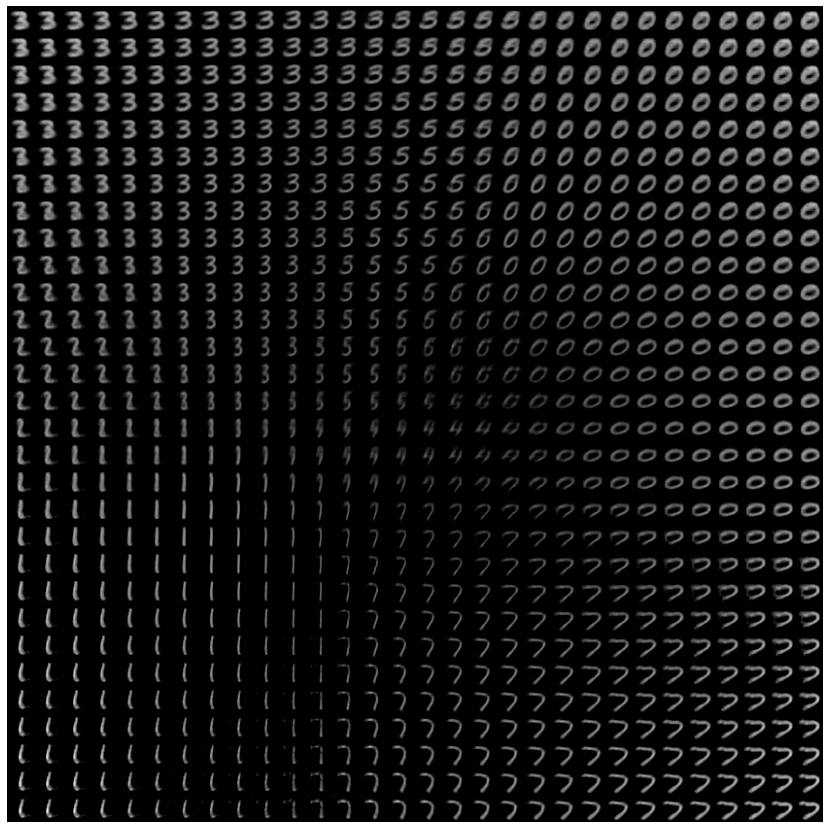

In [28]:
plt.figure(figsize=(15,15))
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()